In [1]:
import numpy as np
import random

from matplotlib import pyplot as plt
%matplotlib inline

from Classifiers import *
from utils import *

In [2]:
train, labels, test = load_from_folders('data/att/')

X_mean, X_std = train.mean(), train.std()
train_norm = (train - X_mean)/X_std
test_norm = (test - X_mean)/X_std

X_mean2, X_std2 = train.mean(axis=0), train.std(axis=0)
train_norm2 = (train - X_mean2)/X_std2
test_norm2 = (test - X_mean2)/X_std2

In [3]:
scale_clf = ScaleClassifier(scales=[4])       #norm2
rp_clf = RandomPointsClassifier(n_points=660) #norm2
dct_clf = DCTClassifier(size=5)               #norm2
dft_clf = DFTClassifier(clipped=False)
hist_clf = HistogramClassifier(size=7)
grad_clf = GradientClassifier()

In [4]:
def classify_collab(clfs, img_idx, weights=None, vote='soft', use_norm=None):   
    if weights is None:
        weights = [1 for x in clfs]
    if use_norm is None:
        use_norm = [0 for x in clfs]
        
    assert(len(clfs) == len(weights))
    assert(len(clfs) == len(use_norm))
        
    all_dist = []
    for i,clf in enumerate(clfs):
        img = train[img_idx] if use_norm[i]==0 else train_norm2[img_idx]
        distances = np.array(list(map(lambda img2: clf.Distance(img, img2),
                                      test if use_norm[i]==0 else test_norm2)))
        distances = weights[i] * distances / np.sum(distances)
        all_dist.append(distances)
        
    if vote=='soft':
        return np.mean(all_dist, axis=0).argmin()
    else:
        votes = np.argmin(all_dist, axis=1)
        return np.bincount(votes).argmax()

In [5]:
clfs = [scale_clf, rp_clf, dct_clf, dft_clf, hist_clf, grad_clf]

pred = list(map(lambda i: classify_collab(clfs, i, use_norm=[1,1,1,0,0,0], vote='hard'), range(len(train))))
acc = sum(np.array(pred)==np.array(labels))/len(train)
acc

0.9222222222222223

In [ ]:
clfs = [scale_clf, rp_clf, dct_clf, dft_clf, hist_clf, grad_clf]
use_norm=[1,1,1,0,0,0]
n_classes = 10
imgs_per_class = 9

history = [0]
for batch_size in range(1,10):

    cur_train = []
    cur_train_norm = []
    cur_labels = []
    for c in range(n_classes):
        for i in range(imgs_per_class - batch_size + 1):
            k = i + c*imgs_per_class
            cur_train.append(train[k:k+batch_size])
            cur_train_norm.append(train_norm2[k:k+batch_size])
            cur_labels.append(labels[k])
    cur_train = np.array(cur_train)
    cur_train_norm = np.array(cur_train_norm)


    all_pred = []
    for i,clf in enumerate(clfs):
        pred = []
        for img_idx in range(len(cur_train)):
            imgs = cur_train[img_idx] if use_norm[i]==0 else cur_train_norm[img_idx]

            all_dist = []
            for img in imgs:
                distances = np.array(list(map(lambda img2: clf.Distance(img, img2),
                                              test if use_norm[i]==0 else test_norm2)))
                distances = distances / np.sum(distances)
                all_dist.append(distances)

            votes = np.argmin(all_dist, axis=1)
            pred.append(np.bincount(votes).argmax())
        all_pred.append(pred)

    all_pred = np.array(all_pred).transpose()
    final = []
    for x in all_pred:
        final.append(np.bincount(x).argmax())
    acc = sum(np.array(final)==np.array(cur_labels))/len(cur_train)
    history.append(acc)
    
x_points = [i*40 for i in range(10)]
plt.plot(x_points, history)
print("Зависимость от числа тестовых изображений")

Зависимость от числа тестовых изображений


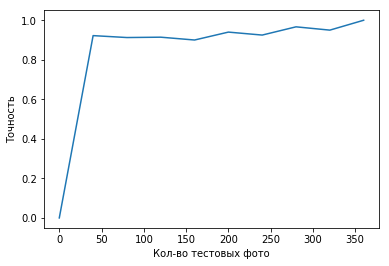

In [8]:
plt.plot(x_points, history)
plt.xlabel('Кол-во тестовых фото')
plt.ylabel('Точность')
print("Зависимость от числа тестовых изображений")
